Use the annotated data to train a model to classify the remaining unlabelled pixels.

In [21]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
!pwd

/content


In [49]:
#image_path = '/Users/Mark/fruitpunch/coral_detection/data/'
image_path = '/content/gdrive/MyDrive/Reef Support Benthic Data/SEAVIEW/PAC_AUS/'
image_files = glob.glob(image_path + 11*'?' + '.jpg')
print(f"{len(image_files)} images found")

2657 images found


In [50]:
# select N images randomly 
import random

N = 10

out = random.sample(image_files,N)

In [51]:
#!ls "{image_path}"

In [52]:
annot_path = '/content/gdrive/MyDrive/Reef Support Benthic Data/SEAVIEW/tabular-data/'
annot_file = 'annotations_PAC_AUS.csv'
df = pd.read_csv(annot_path + annot_file, index_col=0)
df.shape

(186420, 7)

In [53]:
# index column was set to be the `quadratid`
# this numbers refers to the name of the image
# create a list of photo quadratids to pare down the annotations data frame
# so it contains only the relevant data
ids = [int(os.path.basename(fname).rstrip('.jpg')) for fname in image_files]
df = df.loc[ids]
df.shape

(186420, 7)

In [55]:
# now loop over the images, and extract the pixel rgb values from the label coordinates

df[['r','g','b']] = int(0)

for ctr, image_file in enumerate(image_files):
    id = int(os.path.basename(image_file).rstrip('.jpg'))
    #print(image_file, id)
    img = mpimg.imread(image_file)
    df.loc[id,['r','g','b']] = img[df.loc[id]['x'], df.loc[id]['y'], :] 
    print(f'{ctr+1}/{len(image_files)}',end='\r') 

IndexError: ignored

In [ ]:
df.head()

,y,x,label_name,label,func_group,method,data_set,r,g,b
quadratid,,,,,,,,,,
11004109702,536,663,Epilithic Algal Matrix,DSUB,Algae,random,test,57,41,41
11004109702,431,800,Epilithic Algal Matrix,DSUB,Algae,random,test,221,211,212
11004109702,522,434,Turf algae,Turf,Algae,random,test,185,175,184
11004109702,153,802,Epilithic Algal Matrix,DSUB,Algae,random,test,109,118,161
11004109702,326,83,Favidae-Mussidae massive/meandroid,FAV-MUS,Hard Coral,random,test,60,67,86


Now attempt to train a model on Algae vs non-Algae

In [ ]:
df['func_group'].value_counts()

Algae                  518
Hard Coral             486
Other                  164
Soft Coral             124
Other Invertebrates      8
Name: func_group, dtype: int64

In [ ]:
# define the target as coral or other
df['is_coral'] = df['func_group'].str.contains('Coral')

In [ ]:
df['is_coral'].value_counts()

False    690
True     610
Name: is_coral, dtype: int64

Now the modelling

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['r','g','b']], 
                                                    df['is_coral'], 
                                                    train_size=0.7)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier().fit(X_train, y_train)

# {'n_estimators': 1000,
#  'min_samples_split': 10,
#  'min_samples_leaf': 2,
#  'max_features': 'sqrt',
#  'max_depth': 10,
#  'bootstrap': True}

In [ ]:
rfc.score(X_test, y_test)

0.731457800511509

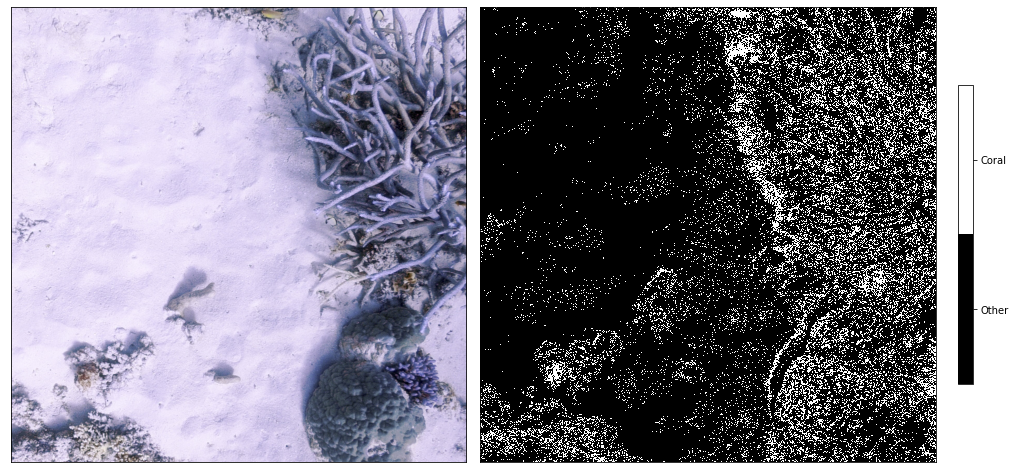

In [ ]:
# plot a randomly selected example

from numpy.random import default_rng
rng = default_rng()
rand_int = rng.integers(0,len(image_files)-1,1)[0]

# read rgb image
img = mpimg.imread(image_files[rand_int])


# predict coral or not coral
y_pred = rfc.predict(img.reshape((-1,3))).reshape(img.shape[0:-1])


# make the figure
import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['black','white'])

fig, ax = plt.subplots(1,2,figsize=(14,7), constrained_layout=True)

ax[0].imshow(img);
im = ax[1].imshow(y_pred, cmap=cmap, interpolation='None');

for tax in ax:
    tax.axes.xaxis.set_visible(False)
    tax.axes.yaxis.set_visible(False)

cbar = fig.colorbar(im, ax=ax[1], shrink=0.6, ticks=[0.25, 0.75]);
cbar.ax.set_yticklabels(['Other','Coral']);

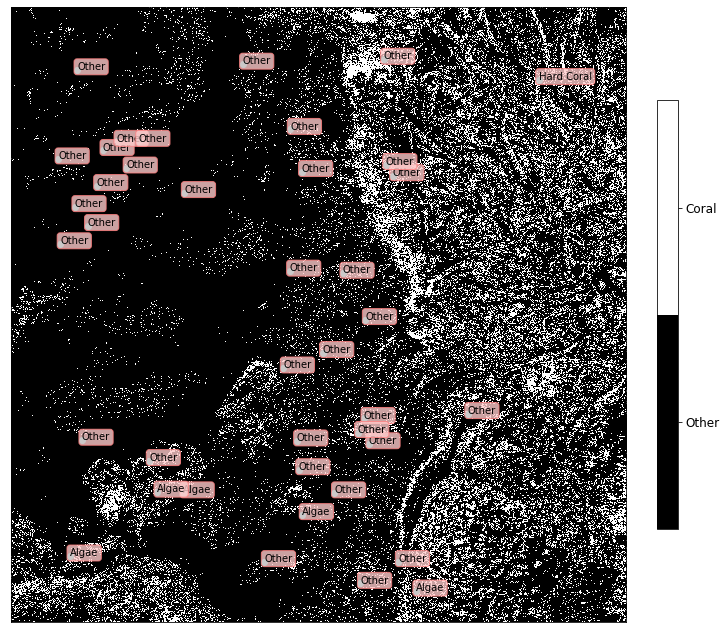

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10), constrained_layout=True)
ax.imshow(y_pred, cmap=cmap, interpolation='None');
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cbar = fig.colorbar(im, ax=ax, shrink=0.6, ticks=[0.25, 0.75]);
cbar.ax.set_yticklabels(['Other','Coral'], fontsize=12);

id = int(os.path.basename(image_files[rand_int]).rstrip('.jpg'))

ax.scatter(df.loc[id,"x"], df.loc[id,"y"], color="c");

for k, s in enumerate(df.loc[id]['func_group']):
    x = df.loc[id]['x'].iloc[k]
    y = df.loc[id]['y'].iloc[k]
    plt.text(x, y, s, color='k', fontsize=10, 
                      bbox=dict(boxstyle="round", 
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      alpha=0.8))

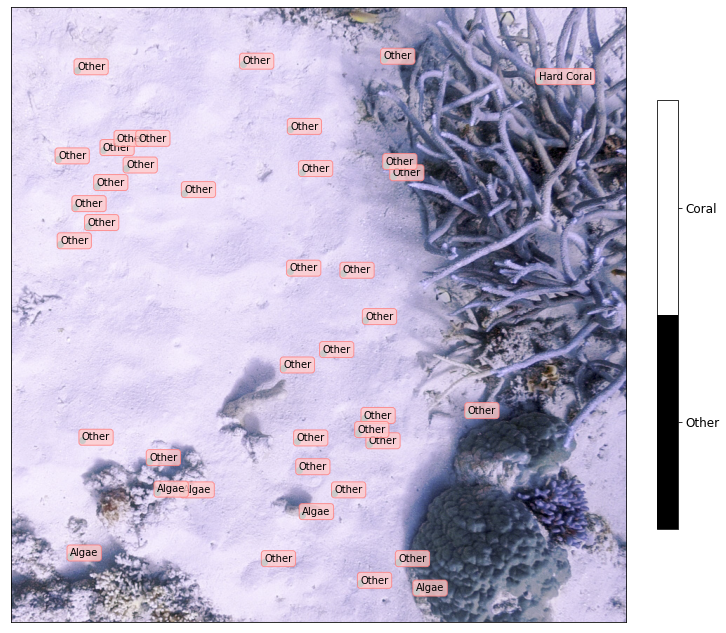

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10), constrained_layout=True)
ax.imshow(img);
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cbar = fig.colorbar(im, ax=ax, shrink=0.6, ticks=[0.25, 0.75]);
cbar.ax.set_yticklabels(['Other','Coral'], fontsize=12);

ax.scatter(df.loc[id,"x"], df.loc[id,"y"], color="c");

for k, s in enumerate(df.loc[id]['func_group']):
    x = df.loc[id]['x'].iloc[k]
    y = df.loc[id]['y'].iloc[k]
    plt.text(x, y, s, color='k', fontsize=10, 
                      bbox=dict(boxstyle="round", 
                      ec=(1., 0.5, 0.5),
                      fc=(1., 0.8, 0.8),
                      alpha=0.8))

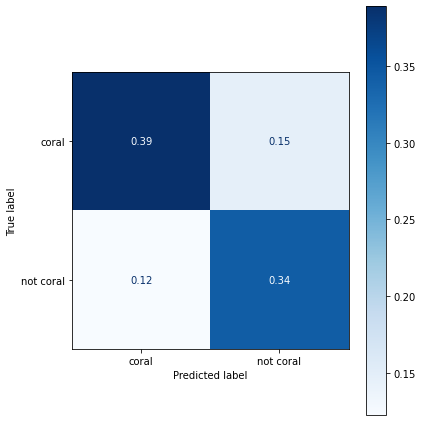

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_confusion_matrix(rfc, X_test, y_test, ax=ax,
                      cmap=plt.cm.Blues, normalize='all',
                      display_labels=["coral","not coral"])
plt.tight_layout()
#fig.savefig("/Users/Mark/Desktop/conf_matrix.png", facecolor="w", edgecolor='none')
plt.show()

Some preliminary hyperparameter tuning

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                               param_distributions = random_grid, 
                               n_iter = 70, cv = 5, random_state = 42, n_jobs = -1)

In [ ]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=70,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [ ]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [ ]:
base_model = RandomForestClassifier()
base_model.fit(X_train, y_train)

print(f'Base model test set accuracy: {100*np.round(base_model.score(X_test, y_test), 2) }%')

Base model test set accuracy: 72.0%


In [ ]:
tuned_model = rf_random.best_estimator_
tuned_model.fit(X_train, y_train)

print(f'Tuned model test set accuracy: {100*np.round(tuned_model.score(X_test, y_test), 2) }%')

Tuned model test set accuracy: 73.0%


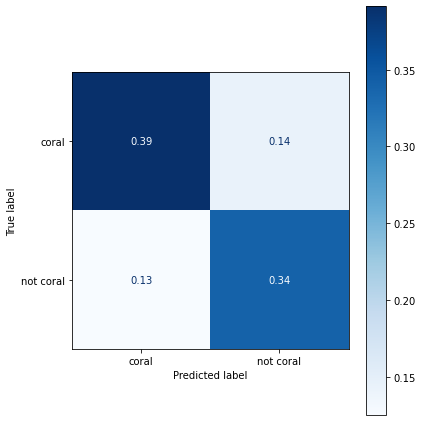

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_confusion_matrix(tuned_model, X_test, y_test, ax=ax,
                      cmap=plt.cm.Blues, normalize='all',
                      display_labels=["coral","not coral"])
plt.tight_layout()
#fig.savefig("/Users/Mark/Desktop/conf_matrix.png", facecolor="w", edgecolor='none')
plt.show()